In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from datetime import datetime
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
N = 1000
X, y = make_moons(N, noise=0.1, random_state=42)

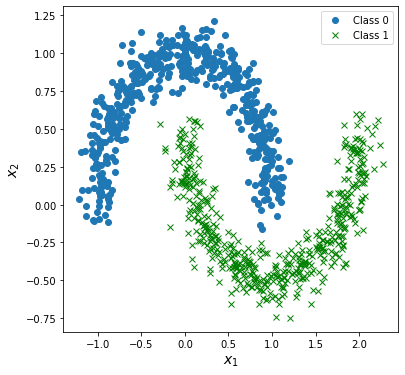

In [3]:
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

fig = plt.figure(figsize=(6,6))
plt.plot(X[idx0,0], X[idx0,1], 'o', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'gx', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend()
#plt.savefig('knn_for_two_classes.png', dpi=600)
plt.show()

In [4]:
X_with_bias = np.c_[np.ones((N, 1)), X]
y_vector = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split( X_with_bias, y_vector, test_size=0.20, random_state=42)

X_train_h = np.c_[X_train, np.square(X_train[:,0]), np.square(X_train[:,1]), np.power(X_train[:,0],3), np.power(X_train[:,1],3)]

X_test_h = np.c_[X_test, np.square(X_test[:,0]), np.square(X_test[:,1]), np.power(X_test[:,0],3), np.power(X_test[:,1],3)]



In [5]:
n_epochs = 1000
learning_rate = 0.01
batch_size = 50
n_batches = int(np.ceil(N / batch_size))


In [7]:
def fetch_batch(X_train, y_train, batch_size):
    indices = np.random.randint(0, len(X_train), batch_size) 
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch



n = 6; #number of features
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
y_proba = tf.sigmoid(y_pred)
loss = tf.losses.log_loss(y, y_proba)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
loss_summary = tf.summary.scalar('log_loss', loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()
#file_writer = tf.summary.FileWriter('/logs', tf.get_default_graph())

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    
    for epoch in range(start_epoch, n_epochs):
        for indices in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train_h, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_h, y: y_test})
        #file_writer.add_summary(summary_str, epoch)
            
            
            
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
        with open(checkpoint_epoch_path, "wb") as f:
            f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_h, y: y_test})
    os.remove(checkpoint_epoch_path)


Epoch: 0 	Loss: 0.6335157
Epoch: 100 	Loss: 0.28657207
Epoch: 200 	Loss: 0.2261961
Epoch: 300 	Loss: 0.19214924
Epoch: 400 	Loss: 0.16897172
Epoch: 500 	Loss: 0.15183668
Epoch: 600 	Loss: 0.13838892
Epoch: 700 	Loss: 0.12751831
Epoch: 800 	Loss: 0.11850956
Epoch: 900 	Loss: 0.11100155


In [8]:
y_pred = (y_proba_val >= 0.5)
precision_score(y_test, y_pred)

0.98

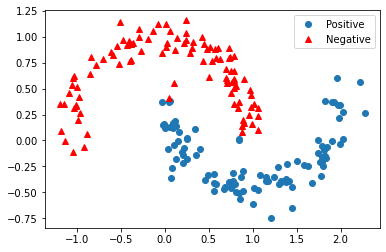

In [13]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'o', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()